# Finding the Best Area to Start a Restaurant Business in San Francisco


In [1]:
import numpy as np 
import pandas as pd 

!pip install geocoder
import geocoder

import requests

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import folium

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 102kB 3.3MB/s 
/kaggle/input/sf-venues/SF venues.csv
/kaggle/input/sf-neighborhood-geojson/Analysis Neighborhoods.geojson
/kaggle/input/sf-demographics-data/SF Demographics Dataset.csv


In [2]:
demographics = pd.read_csv('/kaggle/input/sf-demographics-data/SF Demographics Dataset.csv')

Let's take a quick look at the demographics dataset.

In [3]:
demographics.head()

,Neighborhood,Total Population,Asian,Black/African American,White,Native American Indian,Native Hawaiian/Pacific Islander,Other/Two or More Races,% Latino (of Any Race),Median Household Income
0,Bayview Hunters Point,37600,36.0,28.0,14,0.3,2.0,19,22,55750
1,Bernal Heights,26140,17.0,5.0,57,1.0,0.1,21,29,106914
2,Castro/Upper Market,21090,12.0,3.0,78,0.4,0.4,7,8,127273
3,Chinatown,14820,81.0,1.0,14,0.4,NaN,4,4,21219
4,Excelsior,39340,48.0,2.0,28,1.0,0.4,20,33,72473


In [4]:
demographics.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
Neighborhood                        41 non-null object
Total Population                    41 non-null int64
Asian                               40 non-null float64
Black/African American              40 non-null float64
White                               41 non-null int64
Native American Indian              39 non-null float64
Native Hawaiian/Pacific Islander    38 non-null float64
Other/Two or More Races             41 non-null int64
% Latino (of Any Race)              41 non-null int64
Median Household Income             41 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 3.3+ KB


In [5]:
demographics = demographics.fillna(0)

In [6]:
demographics['White'] = demographics['White'].astype('float64')
demographics['Other/Two or More Races'] = demographics['Other/Two or More Races'].astype('float64')
demographics['% Latino (of Any Race)'] = demographics['% Latino (of Any Race)'].astype('float64')

Let's take a look at the dataset after cleaning.

In [7]:
demographics.describe()

,Total Population,Asian,Black/African American,White,Native American Indian,Native Hawaiian/Pacific Islander,Other/Two or More Races,% Latino (of Any Race),Median Household Income
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.00000,41.000000,41.000000
mean,20532.926829,30.317073,5.885366,51.951220,0.344146,0.656098,11.00000,13.414634,95394.097561
std,15898.671838,17.296588,6.543988,22.279981,0.418157,2.043777,5.97913,9.156898,40661.092664
min,90.000000,0.000000,0.000000,6.000000,0.000000,0.000000,4.00000,0.000000,16404.000000
25%,10720.000000,16.000000,2.000000,38.000000,0.100000,0.100000,7.00000,8.000000,72274.000000
50%,18250.000000,30.000000,3.000000,55.000000,0.200000,0.200000,9.00000,9.000000,97624.000000
75%,25110.000000,40.000000,7.000000,67.000000,0.400000,0.400000,13.00000,16.000000,124668.000000
max,81050.000000,81.000000,28.000000,94.000000,2.000000,13.000000,27.00000,39.000000,180000.000000


We will perform more exploratory data analysis after compiling the restaurant data from Foursquare.

### Restaurant Competition Dataset

In [8]:
neighborhoods = demographics['Neighborhood'].to_list()

longitude = []
latitude = []

for neighborhood in neighborhoods:
    
    # initialize the variable to None
    lat_lng_coords = None

    # loop until getting the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francisco, California'.format(neighborhood))
        lat_lng_coords = g.latlng

    
    # Append the data to the lists
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

Creating a Pandas dataframe containing the location information for each neighborhood.

In [9]:
location = pd.DataFrame({'Neighborhood': neighborhoods, 'Latitude': latitude, 'Longitude': longitude})

Let's take a quick look at the location dataframe.

In [10]:
location.head()

,Neighborhood,Latitude,Longitude
0,Bayview Hunters Point,37.73431,-122.37943
1,Bernal Heights,37.73903,-122.41621
2,Castro/Upper Market,37.76122,-122.44411
3,Chinatown,37.79539,-122.40812
4,Excelsior,37.72104,-122.43160


In [11]:
# Setting Foursquare credentials
CLIENT_ID = 'DASAS2TJ5QYKKAI2QZEPBF0XACCR5JAX0JL4OKNFPI1SYN0K' # your Foursquare ID
CLIENT_SECRET = 'OXNV1ECFX2G4ZYPKP5BDAYI1OZPA1SYVZDIMCKLDSB05OEPE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

This is the function to get all venues near a neighborhood.

In [12]:
"""
def getNearbyVenues(names, latitudes, longitudes, radius=1600, LIMIT=300, categoryId='4d4b7105d754a06374d81259'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues = getNearbyVenues(names=location['Neighborhood'],
                                   latitudes=location['Latitude'],
                                   longitudes=location['Longitude']
                                  )"""

'\ndef getNearbyVenues(names, latitudes, longitudes, radius=1600, LIMIT=300, categoryId=\'4d4b7105d754a06374d81259\'):\n    \n    venues_list=[]\n    for name, lat, lng in zip(names, latitudes, longitudes):\n        print(name)\n            \n        # create the API request URL\n        url = \'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}\'.format(\n            CLIENT_ID, \n            CLIENT_SECRET, \n            VERSION, \n            lat, \n            lng, \n            radius, \n            LIMIT,\n            categoryId)\n            \n        # make the GET request\n        results = requests.get(url).json()["response"][\'groups\'][0][\'items\']\n        \n        # return only relevant information for each nearby venue\n        venues_list.append([(\n            name, \n            lat, \n            lng, \n            v[\'venue\'][\'name\'], \n            v[\'venue\'][\'location\'][\'lat\'], \n     

Let's read the venues CSV file into Pandas dataframe.

In [13]:
venues = pd.read_csv('/kaggle/input/sf-venues/SF venues.csv')

In [14]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview Hunters Point,30,30,30,30,30,30
Bernal Heights,100,100,100,100,100,100
Castro/Upper Market,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Excelsior,70,70,70,70,70,70
Financial District/South Beach,100,100,100,100,100,100
Glen Park,100,100,100,100,100,100
Golden Gate Park,100,100,100,100,100,100
Haight Ashbury,100,100,100,100,100,100


Most of the neighborhoods have 100 data points, as the max limit set by Foursquare API is 100. 

Now let's convert the **venue** dataframe into **venue_count** dataframe with the columns being the amount of each type of restaurant.

In [15]:
venue_count = venues.groupby(['Neighborhood', 'Venue Category'])['Venue'].count()
venue_count = venue_count.unstack()
venue_count = venue_count.fillna(0)

In [16]:
venue_count.head()

Venue Category,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wagashi Place,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Bayview Hunters Point,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bernal Heights,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Castro/Upper Market,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,...,1.0,6.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
Chinatown,0.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
Excelsior,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


## Data Analysis
As the project is focused on creating a visualization for demographics and restaurant competition information for each neighborhood, there is less need to draw insights from the datasets by its own. But it is still quite interesting to examine them especially the demographics dataset. 
<br>


Here we use a bar plot to visualize each neighborhood's population.

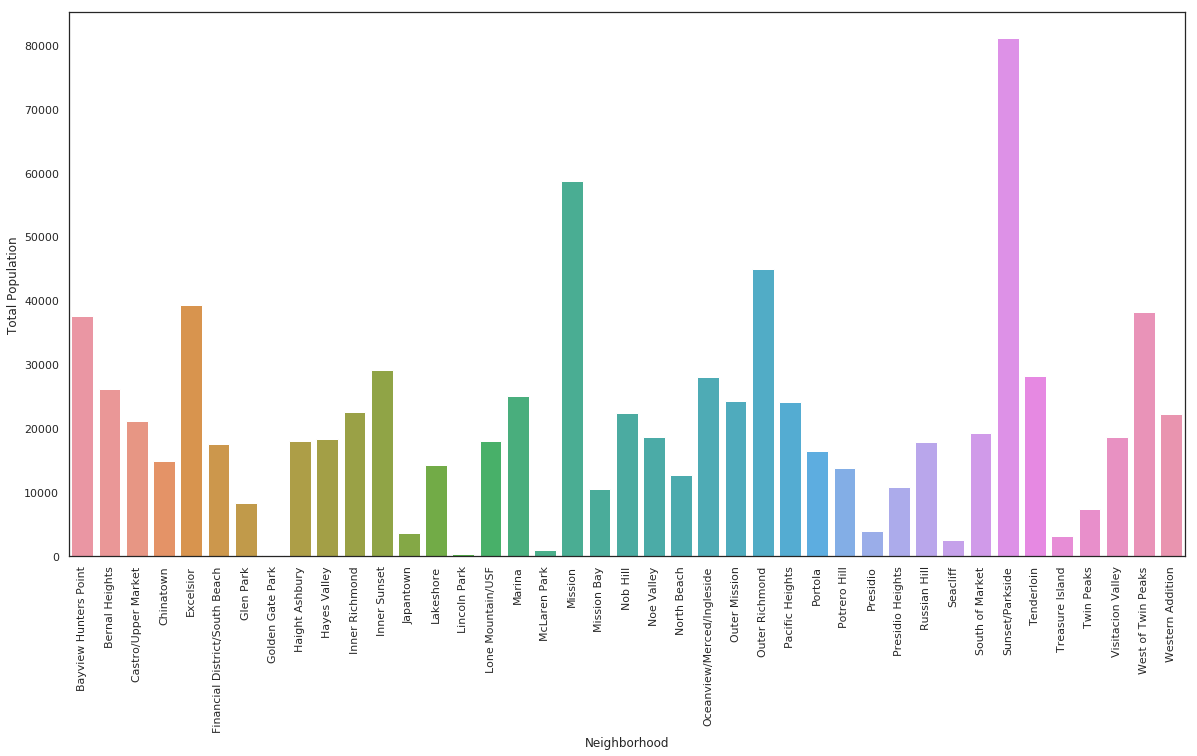

In [17]:
plt.figure(figsize=(20,10))
ax = sns.barplot(demographics['Neighborhood'], demographics['Total Population'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Here we use a box plot to see the distribution of population and whether there's any outliers.

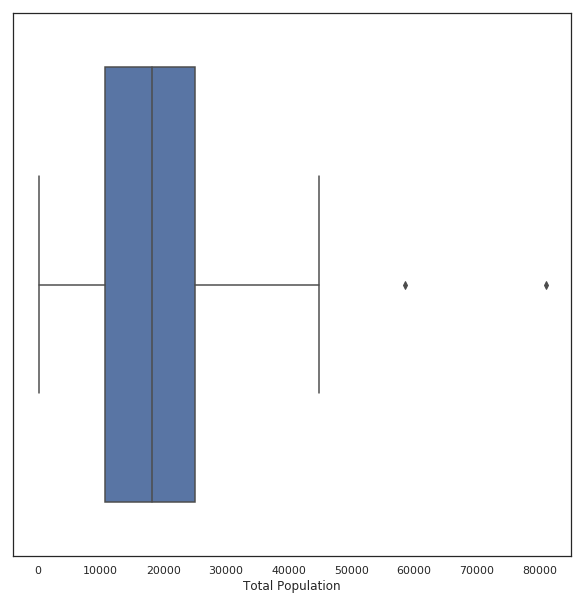

In [18]:
plt.figure(figsize=(10,10))
sns.boxplot(demographics['Total Population'])
plt.show()

Here we use a bar plot to visualize each neighborhood's median household income.

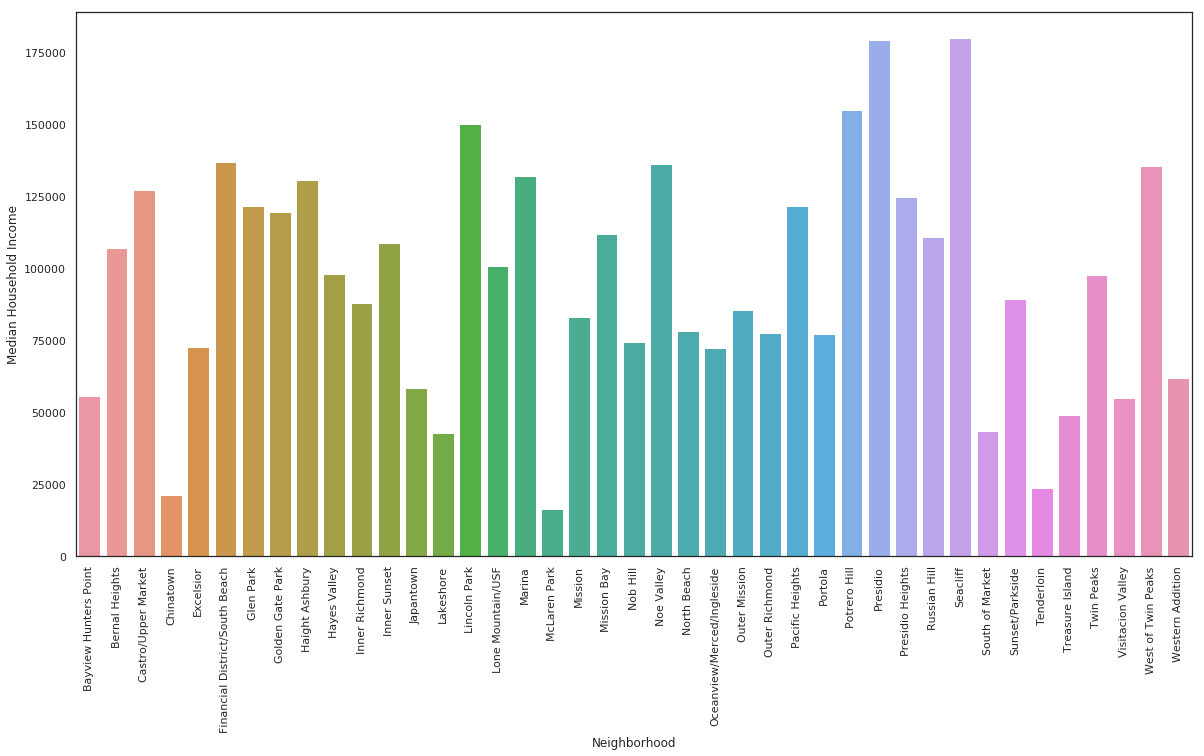

In [19]:
plt.figure(figsize=(20,10))
ax = sns.barplot(demographics['Neighborhood'], demographics['Median Household Income'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Here we use a box plot to see the distribution of median household income and whether there's any outliers.

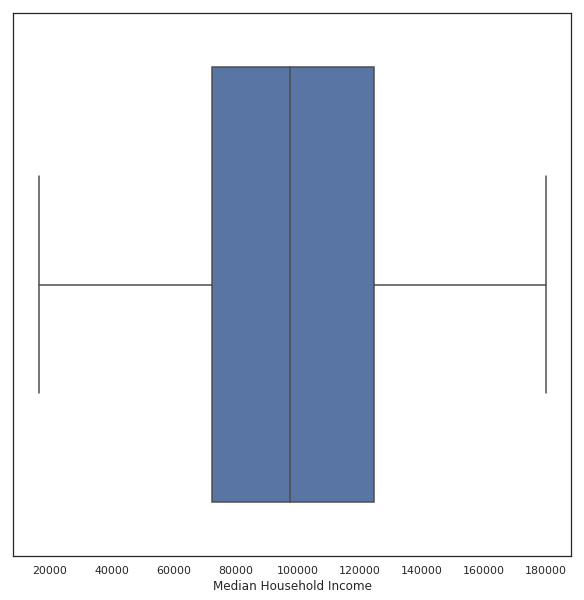

In [20]:
plt.figure(figsize=(10,10))
sns.boxplot(demographics['Median Household Income'])
plt.show()

Here we use a heatmap to visualize the correlation between features.

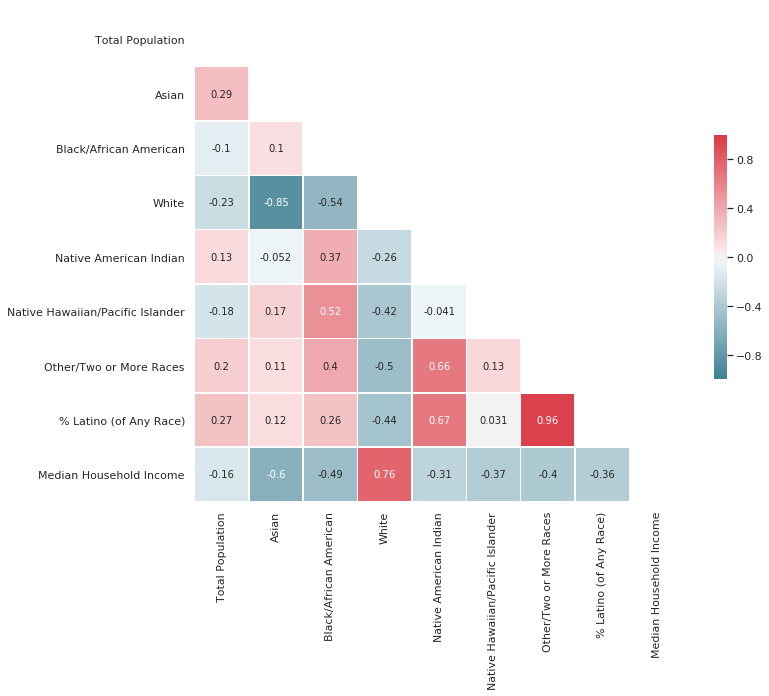

In [21]:
dem_corr = demographics.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(dem_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dem_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

The line of our concern is Median Household Income vs the races. We can see that higher percentage of White household corresponds with higher median household income, while the high percentage of any other race household corresponses negatively with median household income. 

## Mapping the Results
We will create the interactive map visualizing the relevant information here.


This is a function to create the messages used in the map.

In [22]:
import math
def get_info(venue_count, demographics):
    neighs = []
    infos = []
    dem_keys = demographics.iloc[0][['Asian', 'Black/African American', 'White', 'Native American Indian', 'Native Hawaiian/Pacific Islander', 'Other/Two or More Races', '% Latino (of Any Race)']].keys()
    for i in range(len(venue_count)):
        neigh = "<b>" + venue_count.iloc[i].name + "</b>"
        message = ""
        message += neigh
        message = message + '<br>Population: ' + str(demographics['Total Population'][i])
        message += '<br><br>Race (%):<ul> '
        for key in dem_keys:
            message = message + '<li>' + key + ': ' + str(demographics.iloc[i][key]) + '</li>' 
        message += '</ul>'
        message += '<p style="width:200px"><i>Most common restaurant:</i></p><ol>'
        top_keys = venue_count.iloc[i].sort_values(ascending=False).keys()[:5]
        top_values = venue_count.iloc[i].sort_values(ascending=False).values[:5]
        for j in range(5):
            message = message + '<li>' + top_keys[j] + ': ' + str(math.trunc(top_values[j])) + '</li>'
        message += '</ol>'
        neighs.append(neigh)
        infos.append(message)
    return neighs, infos

Here we create the map with Folium.

In [23]:
m = folium.Map(
    location=[37.7749, -122.4194],
    zoom_start=12  
)

restaurants = folium.map.FeatureGroup()

for neighborhood, lat, lng in zip(location['Neighborhood'], location['Latitude'], location['Longitude']):
    restaurants.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(location['Latitude'])
longitudes = list(location['Longitude'])
neighs, infos = get_info(venue_count, demographics)



for lat, lng, neigh, info in zip(latitudes, longitudes, neighs, infos):
    folium.map.Marker([lat, lng], popup=folium.map.Popup(html=info, parse_html=False, max_width='300px'), tooltip=neigh).add_to(m)    
    
m.add_child(restaurants)

In [24]:
m.save('map.html') 